## Importing required libraries

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten, BatchNormalization,Dropout
import matplotlib.pyplot as plt
from keras import callbacks
import numpy as np
from keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
import seaborn as sns
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

## Data Preprocessing

In [11]:
batch_size=32
img_size=48
train_datagen = ImageDataGenerator(
                    rescale=1./255, 
                    rotation_range=30,
                    shear_range=0.3,
                    #zoom_range=0.3,
                    width_shift_range = 0.1,
                    height_shift_range = 0.1,
                    horizontal_flip=True,
                    validation_split=0.3)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        r"D:\Sem 3 Notes\archive\images\train",
        target_size=(img_size, img_size),
        color_mode =  'grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        subset = 'training') 

validation_generator = validation_datagen.flow_from_directory(
        r"D:\Sem 3 Notes\archive\images\train",
        target_size=(img_size, img_size),
        color_mode =  'grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')

test_generator = test_datagen.flow_from_directory(
        r"D:\Sem 3 Notes\archive\images\validation",
        target_size=(img_size, img_size),
        color_mode =  'grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False)

Found 20179 images belonging to 7 classes.
Found 8642 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [12]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

### Tuned Model

In [13]:
from keras.optimizers import Adam,SGD,RMSprop

initializer = tf.keras.initializers.HeUniform(seed=42)
reg = tf.keras.regularizers.L2(l2=0.01)
no_of_classes = 7

model_tuned = Sequential()

#1st CNN layer
model_tuned.add(Conv2D(64,(3,3),padding = 'same', activation='relu',input_shape = (48,48,1), kernel_initializer=initializer, kernel_regularizer=reg))
model_tuned.add(BatchNormalization())
model_tuned.add(MaxPooling2D(pool_size = (2,2)))
model_tuned.add(Dropout(0.25))

#2nd CNN layer
model_tuned.add(Conv2D(128,(5,5),padding = 'same', activation='relu', kernel_initializer=initializer, kernel_regularizer=reg))
model_tuned.add(BatchNormalization())
model_tuned.add(MaxPooling2D(pool_size = (2,2)))
model_tuned.add(Dropout (0.25))

#3rd CNN layer
model_tuned.add(Conv2D(512,(3,3),padding = 'same', activation='relu', kernel_initializer=initializer, kernel_regularizer=reg))
model_tuned.add(BatchNormalization())
model_tuned.add(MaxPooling2D(pool_size = (2,2)))
model_tuned.add(Dropout (0.25))

#4th CNN layer
model_tuned.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_initializer=initializer, kernel_regularizer=reg))
model_tuned.add(BatchNormalization())
model_tuned.add(MaxPooling2D(pool_size=(2, 2)))
model_tuned.add(Dropout(0.25))

model_tuned.add(Flatten())

#Fully connected 1st layer
model_tuned.add(Dense(256, activation='relu'))
model_tuned.add(BatchNormalization())
model_tuned.add(Dropout(0.25))


#Fully connected layer 2nd layer
model_tuned.add(Dense(512, activation='relu'))
model_tuned.add(BatchNormalization())
model_tuned.add(Dropout(0.25))

model_tuned.add(Dense(no_of_classes, activation='softmax'))

model_tuned.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_7 (Batc  (None, 24, 24, 128)     

## Applying callbacks and compiling

In [14]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_tuned = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list_tuned = [checkpoint_tuned,reduce_learningrate]

epochs = 48

model_tuned.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])

## Fitting the Model

In [15]:
history_tuned = model_tuned.fit(train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list_tuned
                                )
model_tuned.save('model.5')

Epoch 1/48
630/630 [==============================] - 417s 659ms/step - loss: 25.1393 - accuracy: 0.1918 - val_loss: 22.8984 - val_accuracy: 0.2638 - lr: 1.0000e-04
Epoch 2/48
630/630 [==============================] - 376s 597ms/step - loss: 21.0500 - accuracy: 0.2285 - val_loss: 18.8767 - val_accuracy: 0.2713 - lr: 1.0000e-04
Epoch 3/48
630/630 [==============================] - 287s 455ms/step - loss: 16.9255 - accuracy: 0.2380 - val_loss: 14.8562 - val_accuracy: 0.2743 - lr: 1.0000e-04
Epoch 4/48
630/630 [==============================] - 280s 444ms/step - loss: 13.0895 - accuracy: 0.2527 - val_loss: 11.2221 - val_accuracy: 0.3019 - lr: 1.0000e-04
Epoch 5/48
630/630 [==============================] - 279s 443ms/step - loss: 9.9099 - accuracy: 0.2683 - val_loss: 8.4587 - val_accuracy: 0.3083 - lr: 1.0000e-04
Epoch 6/48
630/630 [==============================] - 279s 443ms/step - loss: 7.5000 - accuracy: 0.2867 - val_loss: 6.3608 - val_accuracy: 0.3655 - lr: 1.0000e-04
Epoch 7/48
630

INFO:tensorflow:Assets written to: model.5\assets


INFO:tensorflow:Assets written to: model.5\assets


## Comparing Loss

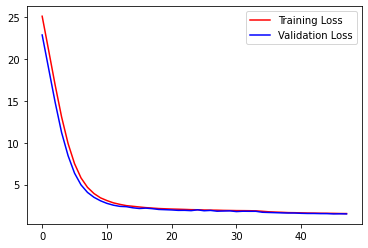

In [16]:
# Comparing loss
plt.plot(history_tuned.history['loss'], label='Training Loss', color='red')
plt.plot(history_tuned.history['val_loss'], label='Validation Loss', color='blue')
plt.legend()
plt.show()

## Comparing Accuracy

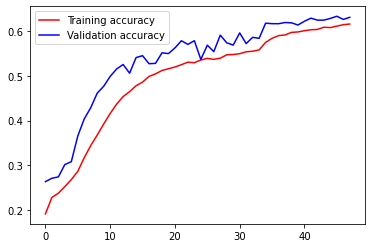

In [17]:
# Comparing accuracy
plt.plot(history_tuned.history['accuracy'], label='Training accuracy', color='red')
plt.plot(history_tuned.history['val_accuracy'], label='Validation accuracy', color='blue')
plt.legend()
plt.show()

In [2]:
from tensorflow.keras.models import load_model
savedModel=load_model(r"D:\Sem 3 Notes\Mini project\model.h5")
savedModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_7 (Batc  (None, 24, 24, 128)     

## Running Model on Webcam

In [8]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array

In [9]:
haar = cv2.CascadeClassifier(r"C:\Users\mehr0\Downloads\haarcascade_frontalface_default.xml")

In [10]:
def detect_face(img):
    coord = haar.detectMultiScale(img)
    
    return coord

**Use Below code run the model on Webcam and detect Emotions**

In [ ]:
# open webcam
webcam = cv2.VideoCapture(0)
    
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# loop through frames
while webcam.isOpened():

    # read frame from webcam 
    status, frame = webcam.read()
    
     # Converting to grayscale image
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

     # apply face detection
    cood = detect_face(gray_frame)

     # loop through detected faces
    for x,y,w,h in cood:
        cv2.rectangle(frame,(x,y),(x+w,y+h), (0,255,0),3)

         # crop the detected face region
        face_crop = np.copy(gray_frame[y:y+h,x:x+w])

        if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
            continue

         # preprocessing for emotion detection model
        face_crop = cv2.resize(face_crop, (48,48))
        face_crop = face_crop.astype("float") / 255.0
        face_crop = img_to_array(face_crop)
        face_crop = np.expand_dims(face_crop, axis=0)

         # apply emotion detection on face
        conf = savedModel.predict(face_crop)[0] # model.predict return a 2D matrix, ex: [[9.9993384e-01 7.4850512e-05]]

        # get label with max accuracy
        idx = np.argmax(conf)
        label = classes[idx]

         #label = "{}: {:.2f}%".format(label, conf[idx] * 100)

         #Y = x - 10 if y - 10 > 10 else y + 10

         # write label and confidence above face rectangle
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                     0.7, (0, 255, 255), 2)

     # display output
    cv2.imshow("Emotion Detection", frame)

     # press "Q" to stop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

 # release resources
webcam.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 142ms/step
